# MacroPhage Cells

In [2]:

import sys
import pickle
import pandas as pd
import scanpy as sc
# 将点大小设为该通路在adata中存在的基因数（归一化到可视范围）
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append('./model/')  # 添加model文件夹到路径

plt.rcParams['pdf.fonttype'] = 42

def load_results(cell_type,n_top=5):
    with open(f'results/real_exp/lung_cov_norm/scKnockPath_results/scKnockPath_normal_COVID-19_{cell_type}.pkl', 'rb') as f:
        model = pickle.load(f)
    
    print(f'scKnockPath selects {len(model.select_pathway(0.2))} pathways under FDR 0.2')
    
    # 定义结果文件路径
    results_base = 'results/real_exp/lung_cov_norm/'
    methods_results = {}
    
    # PADOG结果
    padog_file = os.path.join(results_base, f'PADOG_results/PADOG_COVID-19_vs_normal_{cell_type}.csv')
    if os.path.exists(padog_file):
        padog_results = pd.read_csv(padog_file)
        methods_results['PADOG'] = padog_results
        print(f"✅ PADOG结果加载成功: {padog_results.shape[0]} 通路")
    else:
        print(f"❌ PADOG结果文件未找到: {padog_file}")

    # GSEA结果
    
    gsea_file = os.path.join(results_base, f'GSEA_results/GSEA_COVID-19_vs_normal_{cell_type}.csv')
    if os.path.exists(gsea_file):
        gsea_results = pd.read_csv(gsea_file)
        methods_results['GSEA'] = gsea_results
        print(f"✅ GSEA结果加载成功: {gsea_results.shape[0]} 通路")
    else:
        print(f"❌ GSEA结果文件未找到: {gsea_file}")

    # CAMERA结果
    camera_file = os.path.join(results_base, f'CAMERA_results/CAMERA_COVID-19_vs_normal_{cell_type}.csv')
    if os.path.exists(camera_file):
        camera_results = pd.read_csv(camera_file)
        methods_results['CAMERA'] = camera_results
        print(f"✅ CAMERA结果加载成功: {camera_results.shape[0]} 通路")
    else:
        print(f"❌ CAMERA结果文件未找到: {camera_file}")

    # SCPA结果
    scpa_file = os.path.join(results_base, f'SCPA_results/SCPA_COVID-19_vs_normal_{cell_type}.csv')
    if os.path.exists(scpa_file):
        scpa_results = pd.read_csv(scpa_file)
        methods_results['SCPA'] = scpa_results
        print(f"✅ SCPA结果加载成功: {scpa_results.shape[0]} 通路")
    else:
        print(f"❌ SCPA结果文件未找到: {scpa_file}")

    # scKP结果
    methods_results['scKnockPath'] = pd.DataFrame(model.rank_pathways()[::-1][:len(model.select_pathway(0.2))]['pathway_names']).rename(columns={'pathway_names':'Pathway'})
    print(f"\n总共加载了 {len(methods_results)} 种方法的结果")

    top_by_method = {}
    all_top_pathways = set()
    for method, df in methods_results.items():
        if method == 'GSEA':
            top = df['Term'].head(n_top).tolist()
        else:
            top = df['Pathway'].head(n_top).tolist()
        top_by_method[method] = top
        all_top_pathways.update(top)

    return top_by_method, model, all_top_pathways, methods_results
cell_type = 'elicited macrophage'
top_by_method, model, all_top_pathways, methods_results = load_results(cell_type,n_top=5)
# top_by_method, model, all_top_pathways, methods_results

scKnockPath selects 18 pathways under FDR 0.2
✅ PADOG结果加载成功: 25 通路
✅ GSEA结果加载成功: 104 通路
✅ CAMERA结果加载成功: 52 通路
✅ SCPA结果加载成功: 55 通路

总共加载了 5 种方法的结果


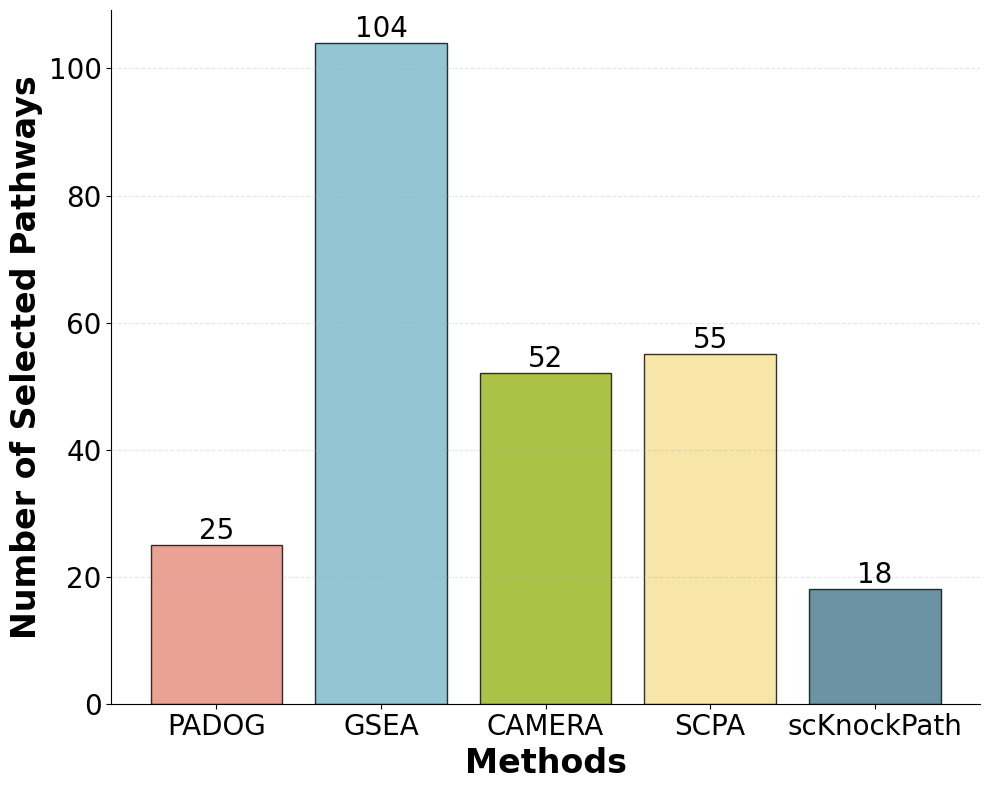

In [2]:
import matplotlib.pyplot as plt

# Extract counts for each method
counts = {method: len(df) for method, df in methods_results.items()}
colors = ['#E58B7B','#78B7C9','#97B319', '#F6E093','#46788E']
# Create bar plot
plt.figure(figsize=(10,8))
bars = plt.bar(counts.keys(), counts.values(), color=colors, edgecolor='black', alpha=0.8)

tick_fontsize = 20
label_fontsize = 24
# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=tick_fontsize)

plt.ylabel('Number of Selected Pathways', fontsize=label_fontsize,weight='bold')
plt.xlabel('Methods', fontsize=label_fontsize,weight='bold')

plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_pathway_counts_bar.pdf')
plt.show()


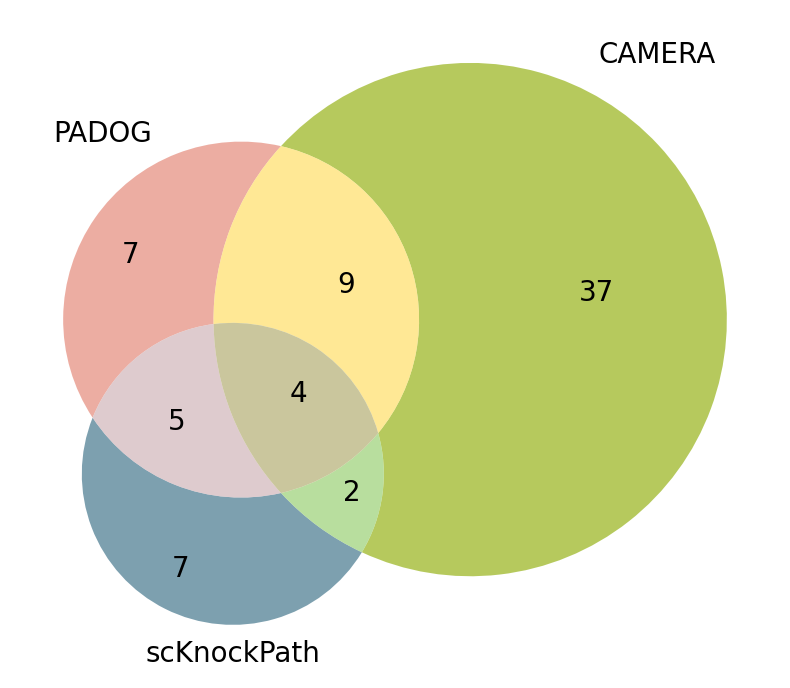

In [3]:
from matplotlib_venn import venn3

import matplotlib.pyplot as plt

# Extract sets of pathways for the three methods
padog_pathways = set(methods_results['PADOG']['Pathway'])
camera_pathways = set(methods_results['CAMERA']['Pathway'])
sckp_pathways = set(methods_results['scKnockPath']['Pathway'])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
colors = ['#E58B7B','#97B319','#46788E']
v = venn3([padog_pathways, camera_pathways, sckp_pathways], 
    set_labels=('PADOG', 'CAMERA', 'scKnockPath'),set_colors=colors, alpha=0.7,)

# Increase font size for set labels and subset numbers
for text in v.set_labels:
    if text: text.set_fontsize(20)
for text in v.subset_labels:
    if text: text.set_fontsize(20)

plt.tight_layout()
plt.savefig(f'results/real_exp/lung_cov_norm/venn_padog_camera_scknockpath_{cell_type}.pdf')
plt.show()

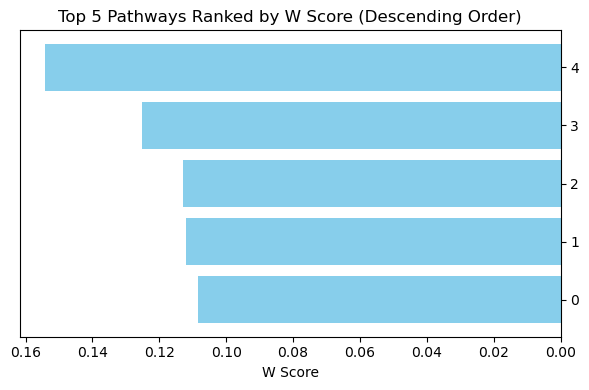

In [5]:
import matplotlib.pyplot as plt

    
pathways = model.rank_pathways()[-5:]['pathway_names']
scores = model.rank_pathways()[-5:]['scores'].values

# Apply short names mapping
short_pathways = pathways

# Further shorten for display by removing prefixes
display_labels = [p.replace('REACTOME_', '').replace('KEGG_', '') for p in short_pathways]

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(range(len(display_labels)), scores, color='skyblue')
# plt.yticks(range(len(display_labels)), display_labels, fontsize=10)
plt.xlabel('W Score')
plt.title('Top 5 Pathways Ranked by W Score (Descending Order)')

# Reverse the x-axis and move y-ticks to the right
ax = plt.gca()
ax.invert_xaxis()
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_top5_pathways_wscore.pdf')
plt.show()

In [30]:
# Get the top pathways from scKnockPath
top_pathways = pathways.tolist()

# Methods to check ranks in
other_methods = ['PADOG', 'CAMERA', 'GSEA']

# Initialize the result dict
pathway_ranks = {}

for pathway in top_pathways:
    ranks = {}
    for method in other_methods:
        df = methods_results[method]
        col = 'Term' if method == 'GSEA' else 'Pathway'
        if pathway in df[col].values:
            rank = df[col].tolist().index(pathway) + 1  # 1-based rank
        else:
            rank = None  # Not in top results
        ranks[method] = rank
    pathway_ranks[pathway] = ranks

pathway_ranks

{'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2': {'PADOG': 18,
  'CAMERA': None,
  'GSEA': 91},
 'REACTOME_CELLULAR_RESPONSES_TO_STIMULI': {'PADOG': 8,
  'CAMERA': 16,
  'GSEA': 37},
 'REACTOME_TOLL_LIKE_RECEPTOR_CASCADES': {'PADOG': 5,
  'CAMERA': 35,
  'GSEA': 30},
 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS': {'PADOG': None,
  'CAMERA': None,
  'GSEA': None},
 'REACTOME_METABOLISM_OF_LIPIDS': {'PADOG': 6, 'CAMERA': 19, 'GSEA': 22}}

## GSEA

In [18]:
import gseapy as gp
def GSEA_test(adata,layer,gs_filepath,gene_names,obs_y,gene_thresh):

    adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X

    if hasattr(adata.layers['lognorm'], "toarray"):
        X = adata.layers['lognorm'].toarray()
    else:
        X = adata.layers['lognorm']
    
    if gene_names is not None: 
        adata.var_names = adata.var[gene_names].astype(str)
    
    df = pd.DataFrame(X, columns=adata.var_names)
    geneset_dict = gp.read_gmt(gs_filepath)
    
    res = gp.gsea(
        data=df.T,
        gene_sets=geneset_dict,
        cls=adata.obs[obs_y],
        permutation_num=1000,
        method='signal_to_noise',
        min_size=gene_thresh,
        seed=42
    )
    
    return res

data_filename='./data/HCA/lung_cov_norm.h5ad'
cell_type='elicited macrophage'
class1='normal'
class2='COVID-19'
layer='lognorm'
geneset_path='/disk/tanbowen/scKnockPath/data/pathway_db/reactome_kegg.gmt'
gene_thresh=15
gene_names='feature_name'
obs_y='disease'
fdr=0.2

adata=sc.read_h5ad(data_filename)
adata = adata[adata.obs['cell_type'] == cell_type, :]
adata=adata[(adata.obs[obs_y]==class2)|(adata.obs[obs_y]==class1),:]

In [19]:
res=GSEA_test(adata=adata,layer=None,gs_filepath=geneset_path,gene_names=gene_names, obs_y=obs_y, gene_thresh=gene_thresh)

/tmp/ipykernel_1890337/1552981172.py:4: ImplicitModificationWarning: Setting element `.layers['lognorm']` of view, initializing view as actual.
  adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X
/disk/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [20]:
import pickle
with open('results/real_exp/lung_cov_norm/GSEA_res_elicited_macrophage.pkl', 'wb') as f:
    pickle.dump(res, f)


In [3]:
with open('results/real_exp/lung_cov_norm/GSEA_res_elicited_macrophage.pkl', 'rb') as f:
    res = pickle.load(f)

In [22]:
terms = res.res2d[res.res2d['FDR q-val'] <= 0.2]['Term'].tolist()

out_dir = './results/real_exp/lung_cov_norm/GSEA_results'
os.makedirs(out_dir, exist_ok=True)

out_file = os.path.join(out_dir, f'GSEA_COVID-19_vs_normal_{cell_type}.csv')

pd.DataFrame({'Term': terms}).to_csv(out_file, index=False)

print(f"Saved {len(terms)} terms to {out_file}")



Saved 104 terms to ./results/real_exp/lung_cov_norm/GSEA_results/GSEA_COVID-19_vs_normal_elicited macrophage.csv


/tmp/ipykernel_2171200/3727045803.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


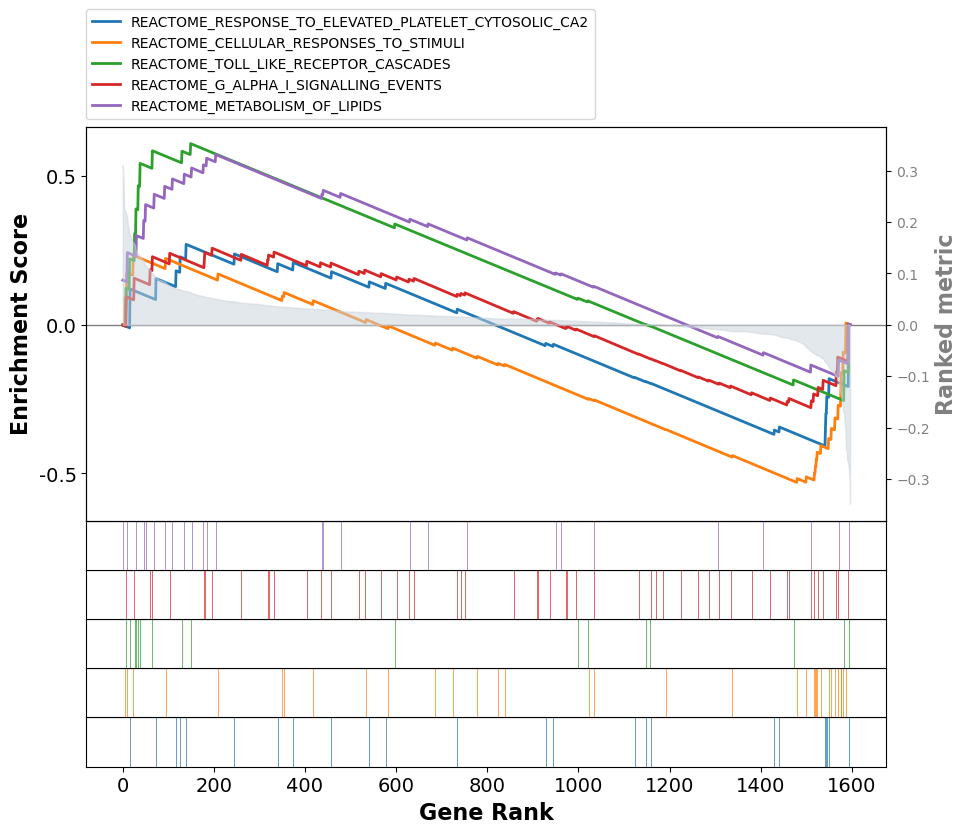

In [9]:
# 保存完整 PDF（使用返回的 Figure 对象并使用 tight bbox）
term = res.res2d.Term
target_pathways = pathways

fig = res.plot(terms=pathways.tolist())  # 返回的为 matplotlib.figure.Figure

# 可根据需要调整尺寸
fig.set_size_inches(10, 8)

# 保证布局并保存完整内容
fig.tight_layout()
fig.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_GSEA_top5_pathways.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

## Genes Frequency

In [4]:
gene2dict=model.transform_geneset_dict()
# model.pathway_dict

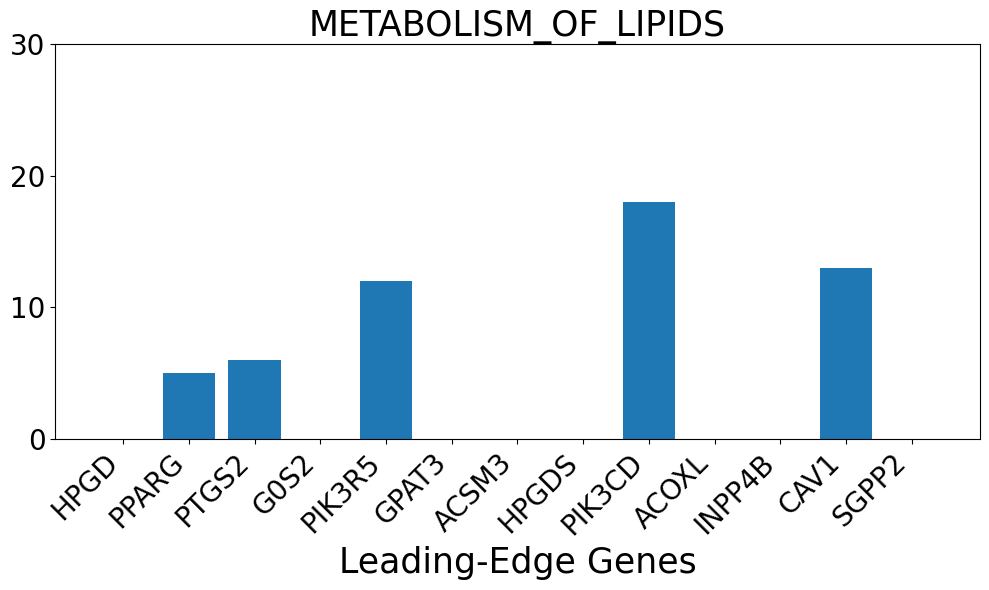

In [11]:
target_pathway='REACTOME_METABOLISM_OF_LIPIDS'

import matplotlib.pyplot as plt

def plot_leading_edge_genes(res, target_pathway, gene2dict,title=None):
    # Compute the number of other pathways for each gene in DEGs
    DEGs = res.res2d[res.res2d['Term'] == target_pathway]['Lead_genes'].iloc[0].split(';')
    other_pathway_counts = []
    for gene in DEGs:
        pathways = gene2dict.get(gene, [])
        other_pathways = [p for p in pathways if p != target_pathway]
        count = len(other_pathways)
        other_pathway_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DEGs)), other_pathway_counts, tick_label=DEGs)
    plt.xlabel('Leading-Edge Genes',size=25)
    if title:
        plt.title(title,size=25)
    plt.xticks(rotation=45, ha='right', size=20)
    plt.yticks([0,10,20,30],size=20)
    plt.tight_layout()
title='METABOLISM_OF_LIPIDS'
plot_leading_edge_genes(res, target_pathway, gene2dict, title)
# plt.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

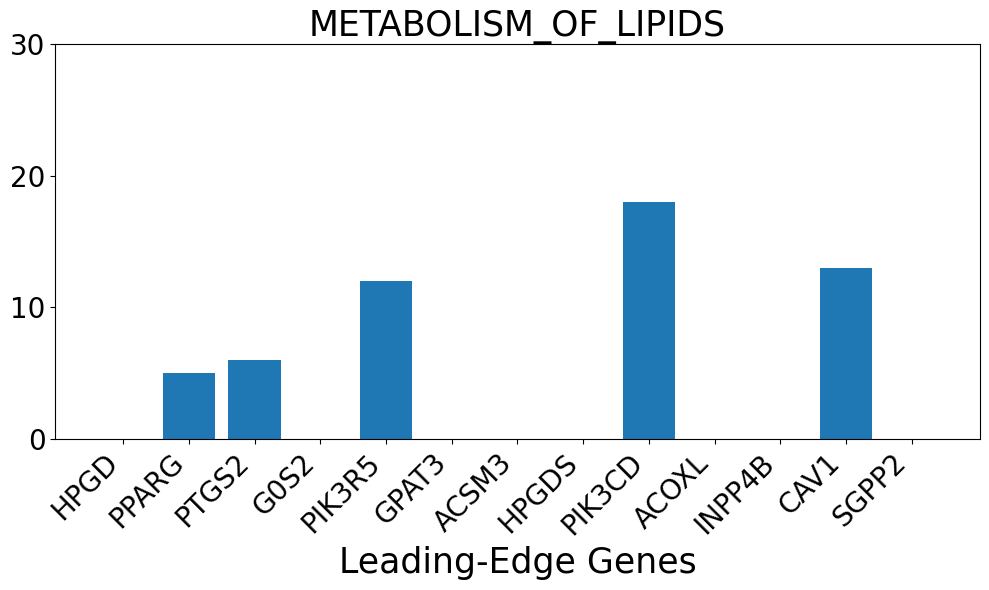

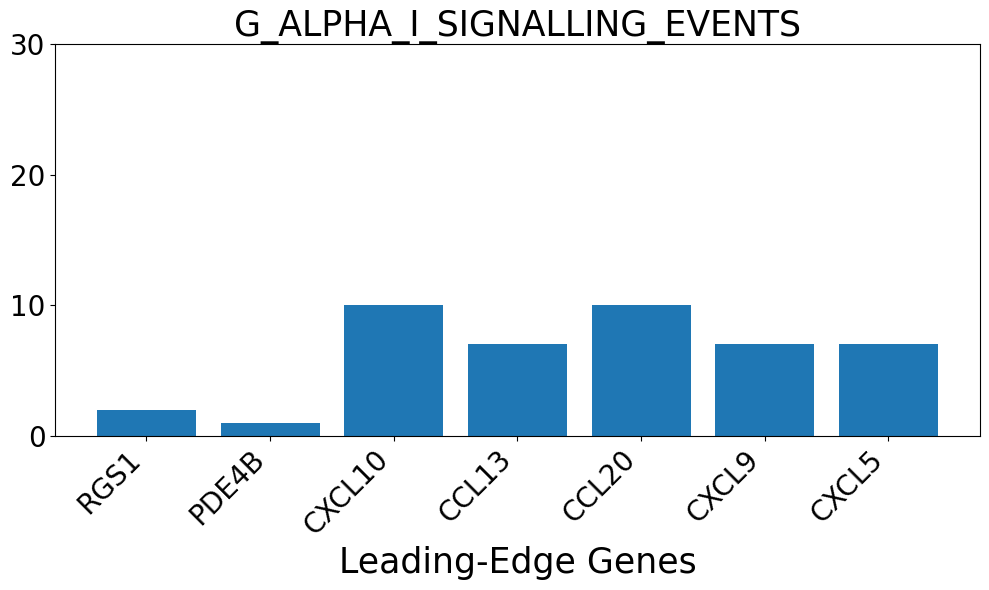

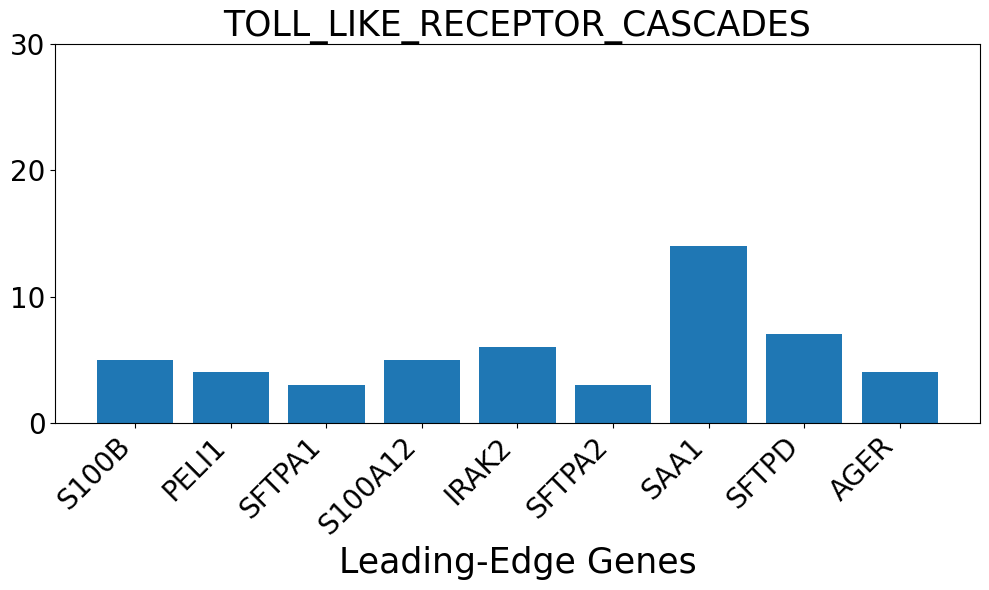

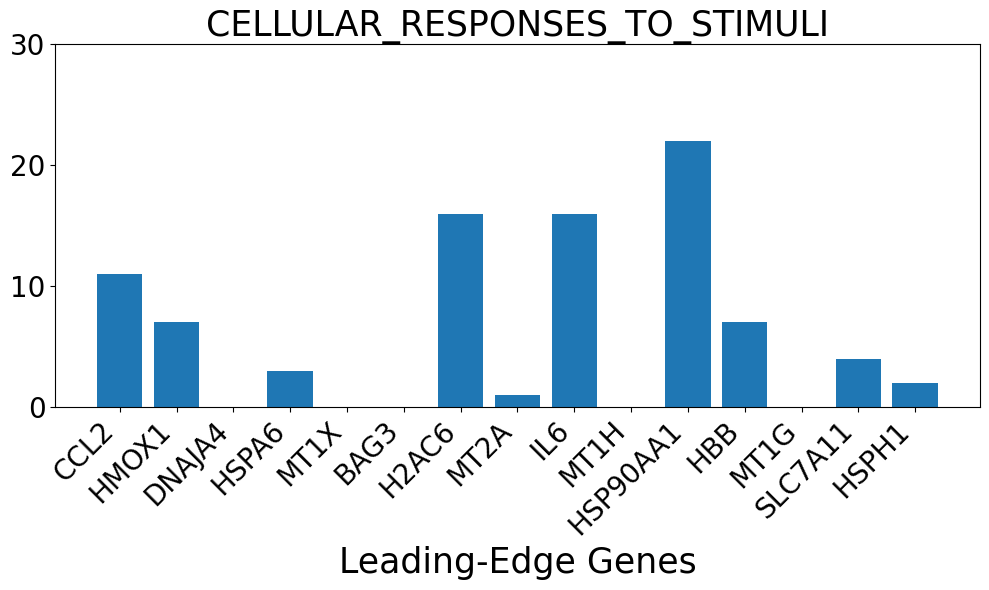

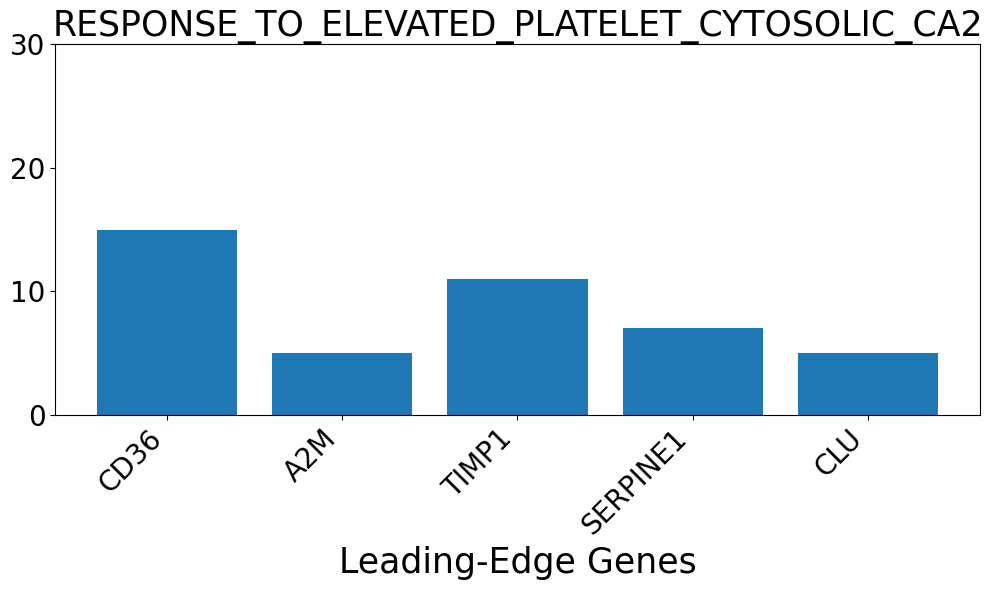

In [12]:
for pathway in top_by_method['scKnockPath']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    plt.savefig(f'results/real_exp/lung_cov_norm/scKnockPath_results/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

In [14]:
target_pathway='REACTOME_G_ALPHA_I_SIGNALLING_EVENTS'
DEGs = res.res2d[res.res2d['Term'] == target_pathway]['Lead_genes'].iloc[0].split(';')

for gene in DEGs:
    print(gene2dict[gene])

['REACTOME_SIGNALING_BY_GPCR', 'REACTOME_G_ALPHA_Q_SIGNALLING_EVENTS', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS']
['REACTOME_SIGNALING_BY_GPCR', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS']
['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION', 'KEGG_CHEMOKINE_SIGNALING_PATHWAY', 'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM', 'REACTOME_SIGNALING_BY_GPCR', 'REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS', 'REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS', 'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS', 'REACTOME_SIGNALING_BY_INTERLEUKINS', 'REACTOME_GPCR_LIGAND_BINDING', 'REACTOME_INTERLEUKIN_10_SIGNALING']
['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION', 'KEGG_CHEMOKINE_SIGNALING_PATHWAY', 'REACTOME_SIGNALING_BY_GPCR', 'REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS', 'REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS', 'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS', 'REACTOME_GPCR_LIGAND_BINDING']
['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTI

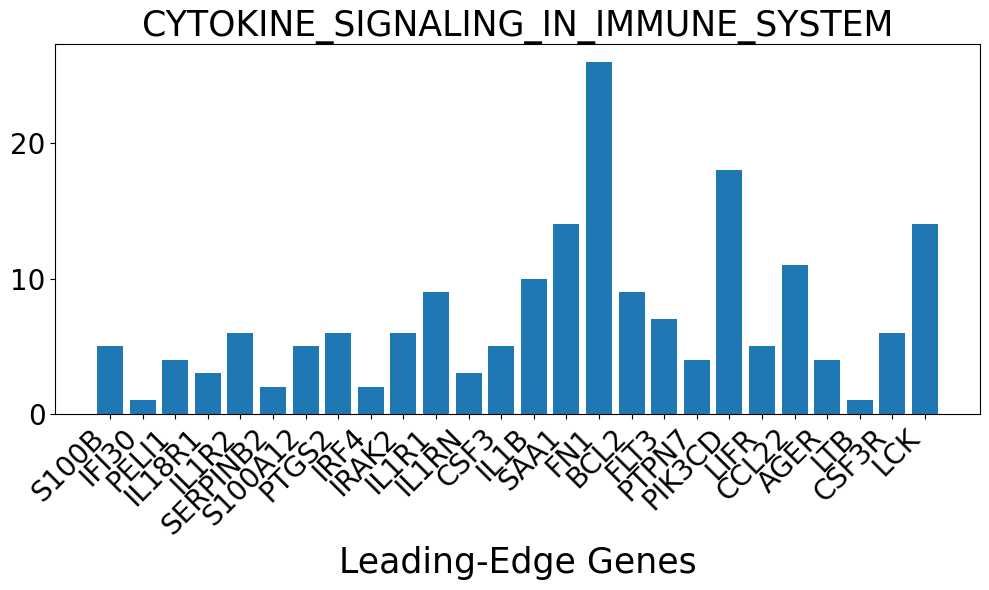

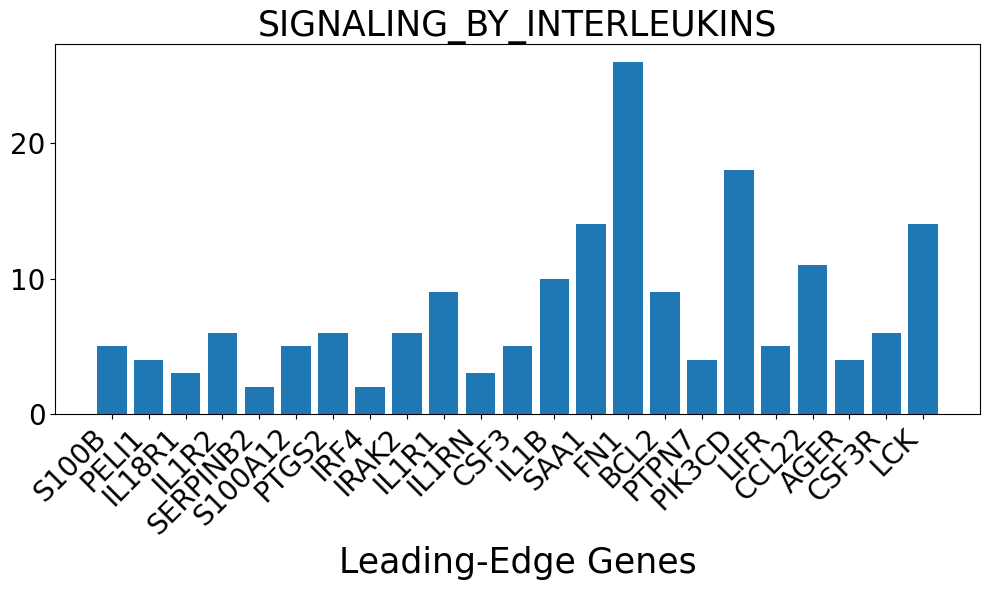

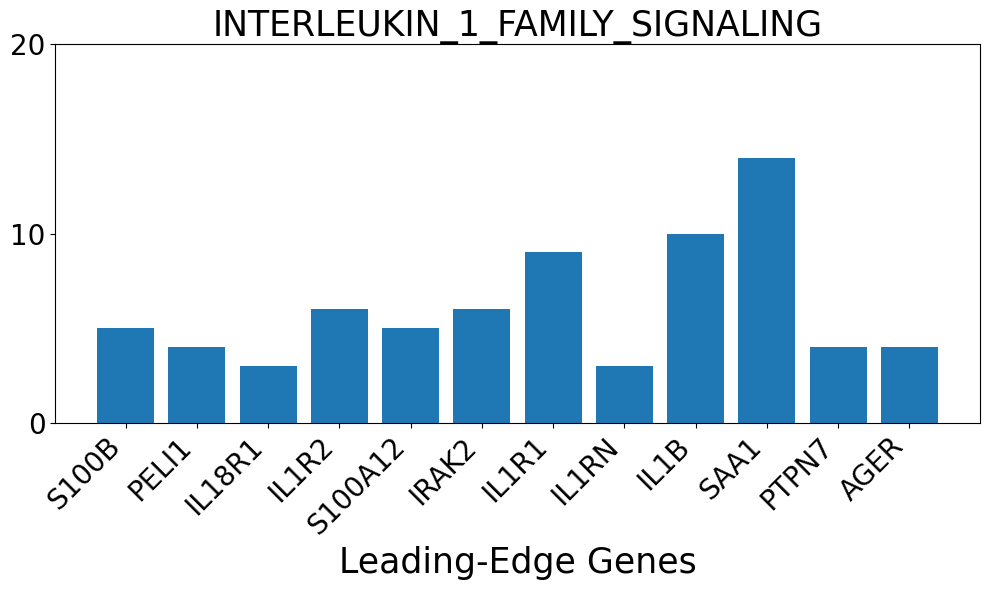

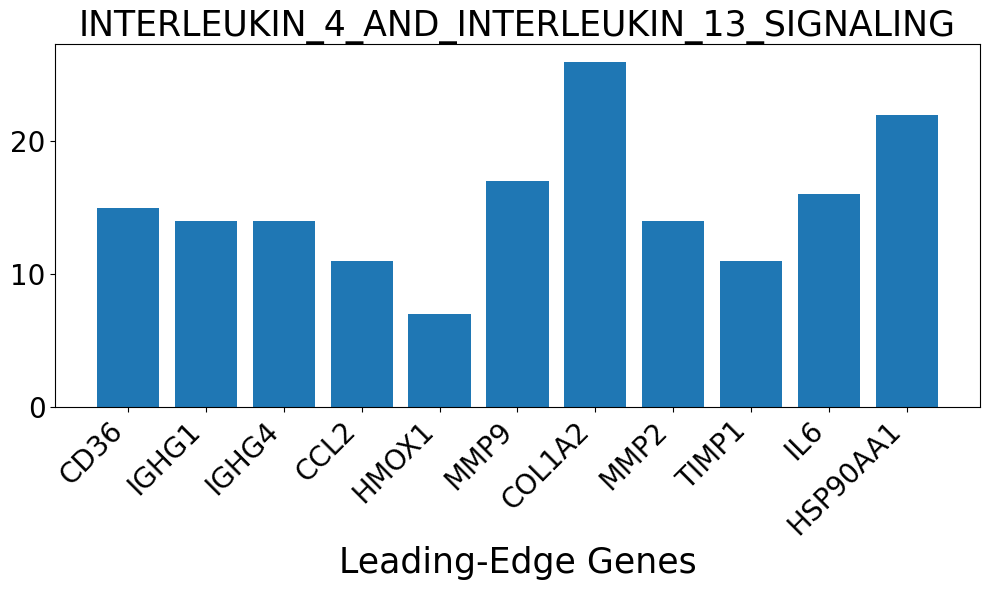

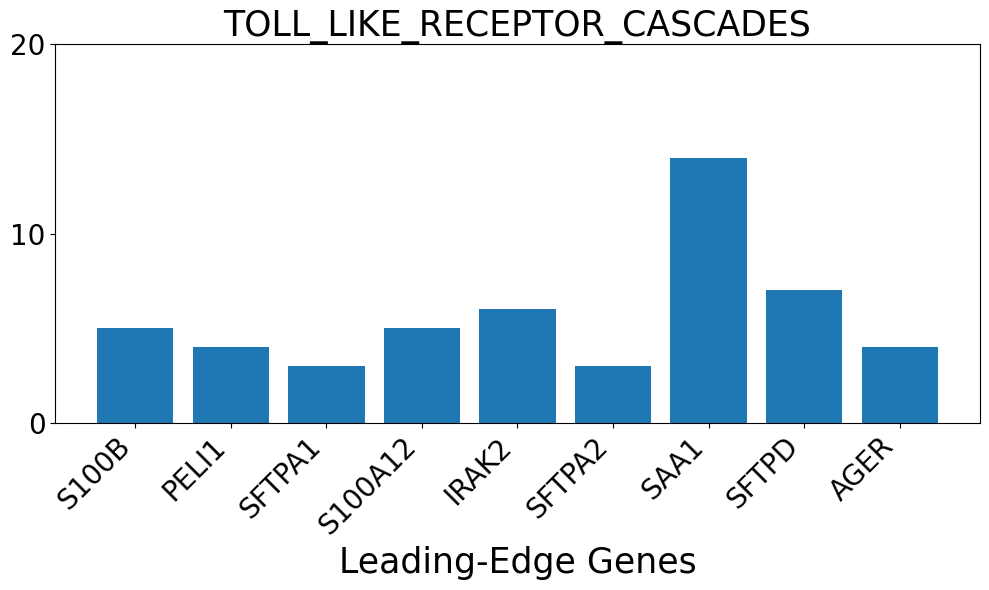

In [9]:
for pathway in top_by_method['PADOG']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    # plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

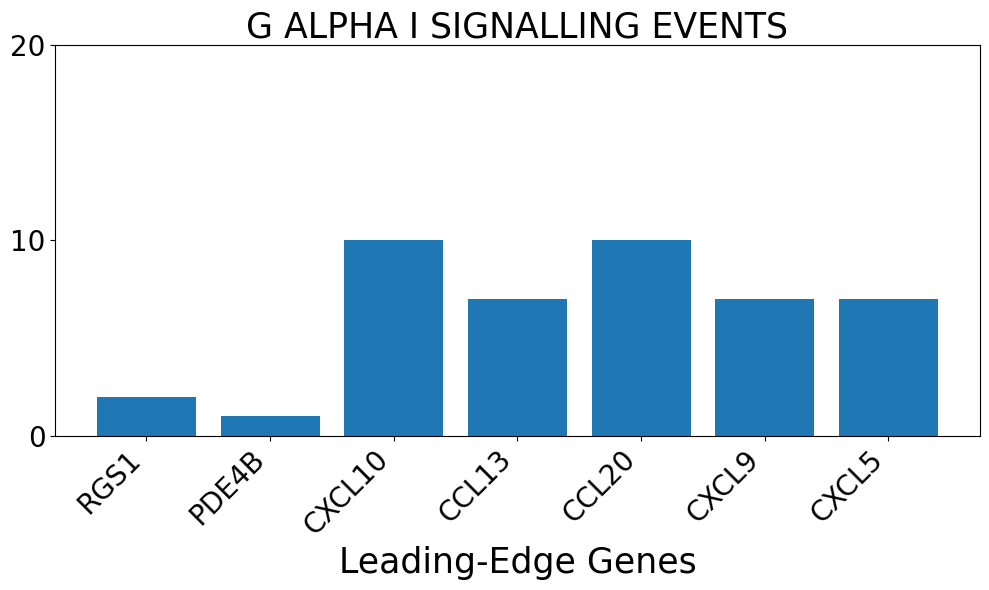

In [35]:
target_pathway='REACTOME_G_ALPHA_I_SIGNALLING_EVENTS'
title='G ALPHA I SIGNALLING EVENTS'
plot_leading_edge_genes(res,target_pathway, gene2dict,title)
plt.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')
plt.show()

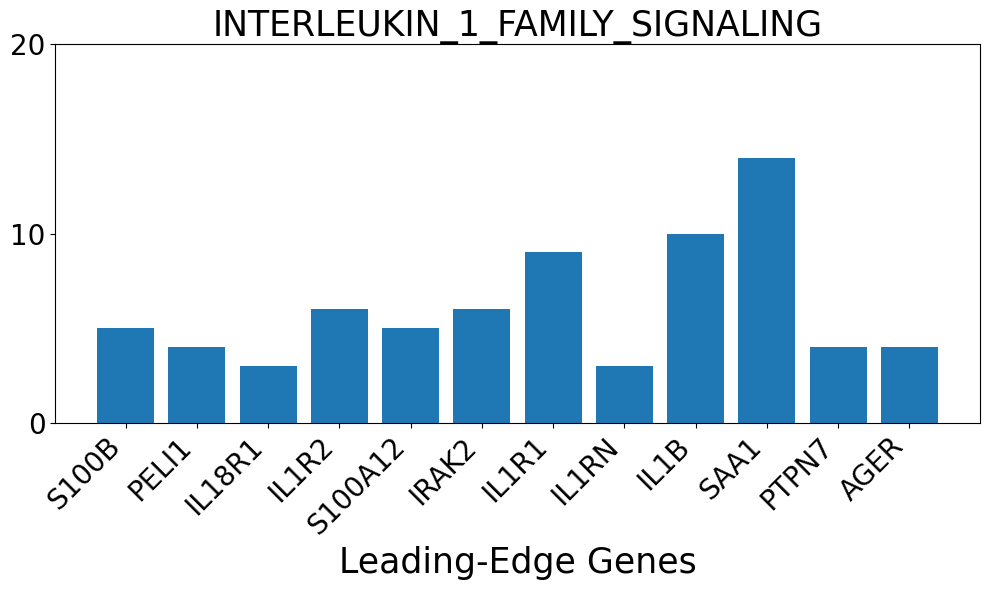

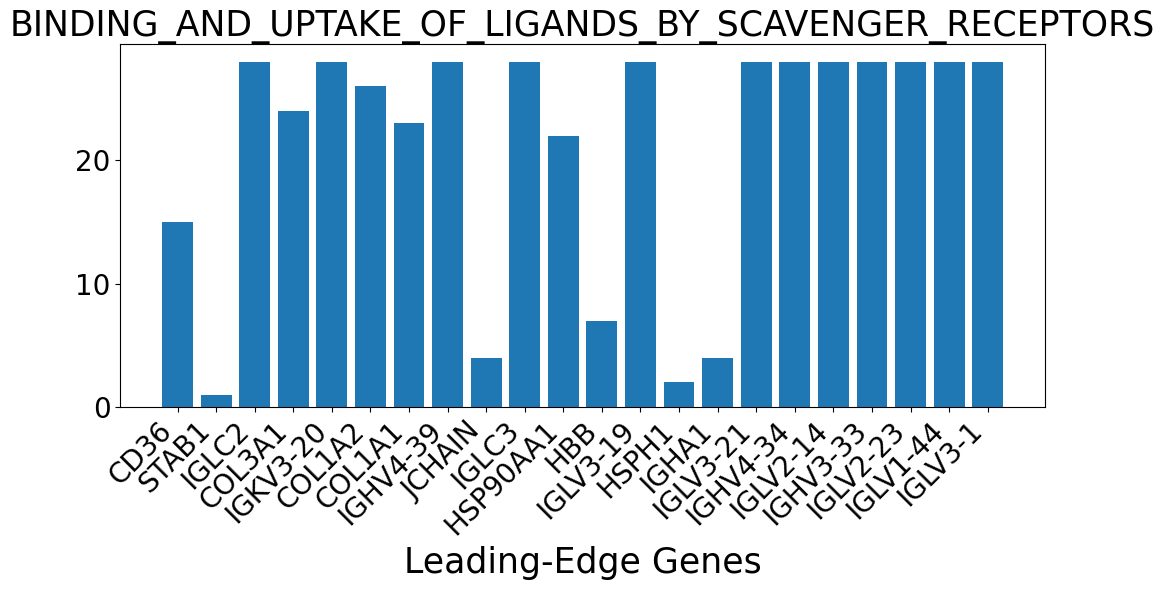

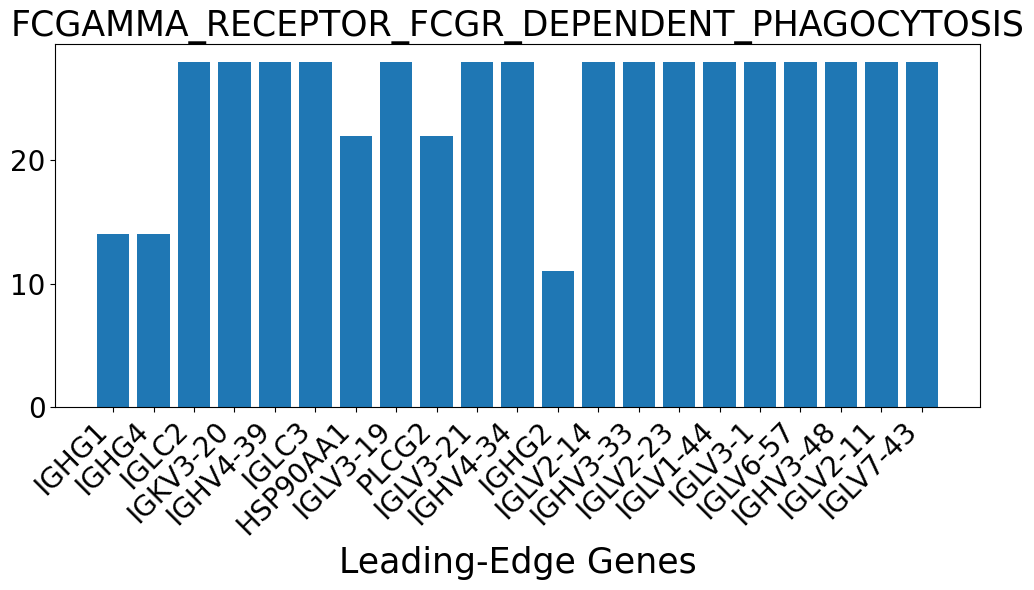

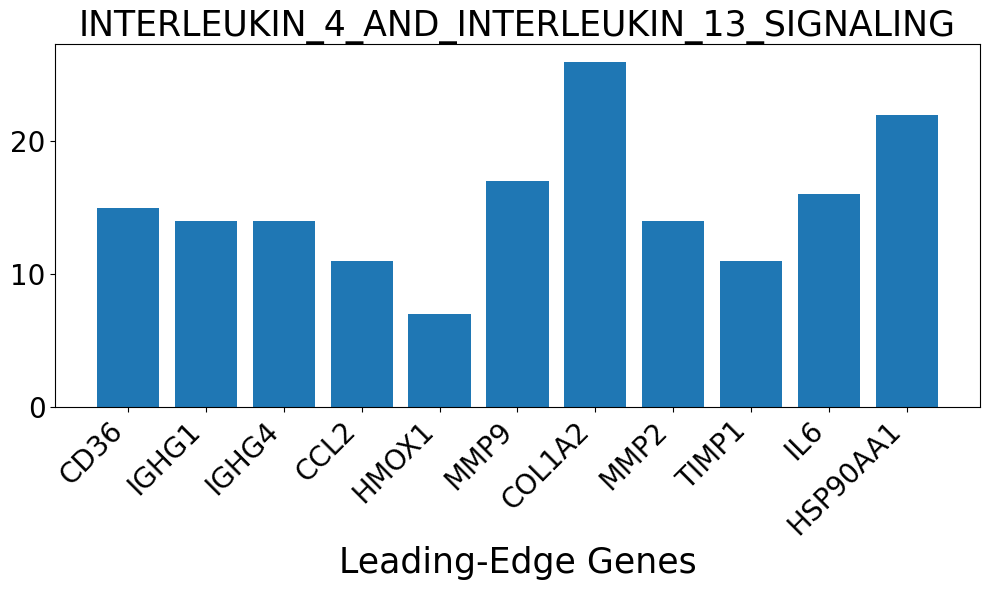

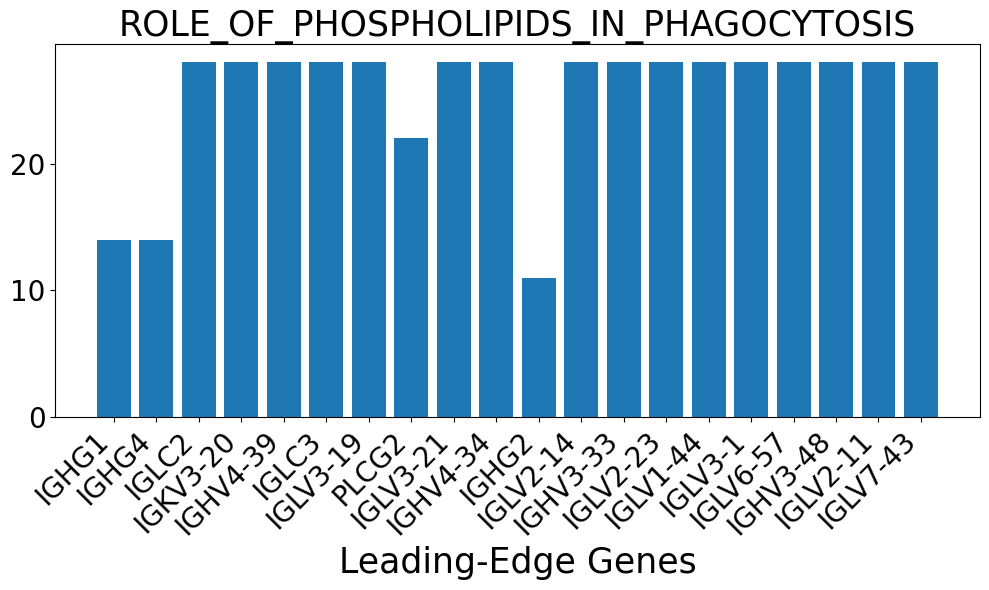

In [8]:
for pathway in top_by_method['CAMERA']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    # plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

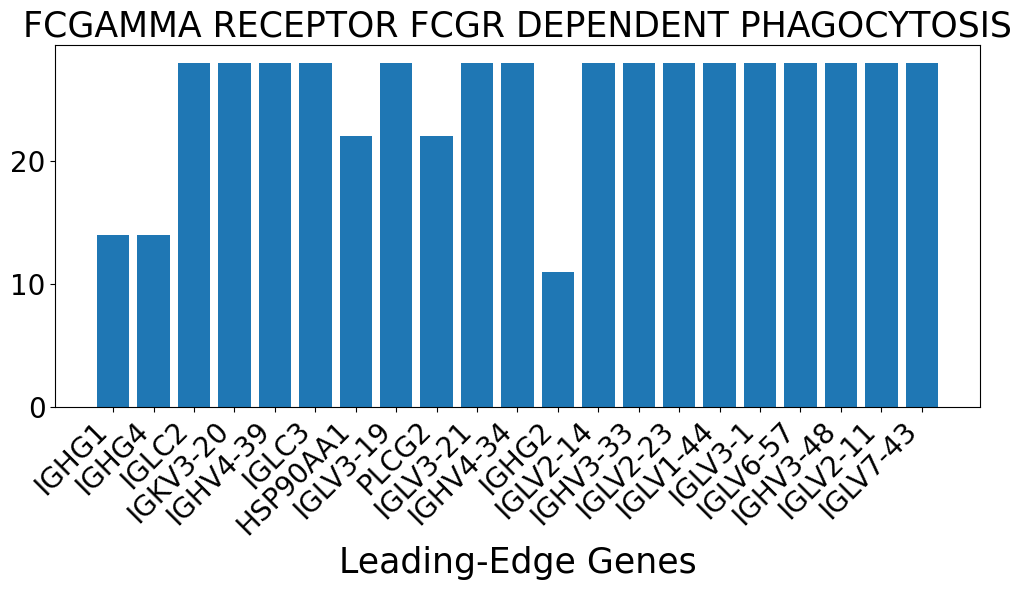

In [41]:
target_pathway='REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS'
title='FCGAMMA RECEPTOR FCGR DEPENDENT PHAGOCYTOSIS'
plot_leading_edge_genes(res,target_pathway, gene2dict,title)
plt.savefig(f'results/real_exp/lung_cov_norm/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')
plt.show()

# GSEA的第一个通路对应的leading edge genes与其他通路的重叠程度较大，说明这些基因在多个通路中都有作用，而不是特异性地参与该通路，而第二个通路的leading edge genes与其他通路的重叠程度较小，说明这些基因更特异性地参与该通路

In [39]:
methods_results['GSEA']

,Term
0,REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING
1,REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX
2,REACTOME_COLLAGEN_DEGRADATION
3,REACTOME_ACTIVATION_OF_MATRIX_METALLOPROTEINASES
4,REACTOME_INTRACELLULAR_SIGNALING_BY_SECOND_MES...
...,...
99,REACTOME_FC_EPSILON_RECEPTOR_FCERI_SIGNALING
100,REACTOME_INFECTIOUS_DISEASE
101,REACTOME_MEMBRANE_TRAFFICKING
102,REACTOME_CELL_JUNCTION_ORGANIZATION


{'PADOG': ['REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
  'REACTOME_SIGNALING_BY_INTERLEUKINS',
  'REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING',
  'REACTOME_INTERLEUKIN_4_AND_INTERLEUKIN_13_SIGNALING',
  'REACTOME_TOLL_LIKE_RECEPTOR_CASCADES'],
 'CAMERA': ['REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING',
  'REACTOME_BINDING_AND_UPTAKE_OF_LIGANDS_BY_SCAVENGER_RECEPTORS',
  'REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS',
  'REACTOME_INTERLEUKIN_4_AND_INTERLEUKIN_13_SIGNALING',
  'REACTOME_ROLE_OF_PHOSPHOLIPIDS_IN_PHAGOCYTOSIS'],
 'scKnockPath': ['REACTOME_METABOLISM_OF_LIPIDS',
  'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS',
  'REACTOME_TOLL_LIKE_RECEPTOR_CASCADES',
  'REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2']}

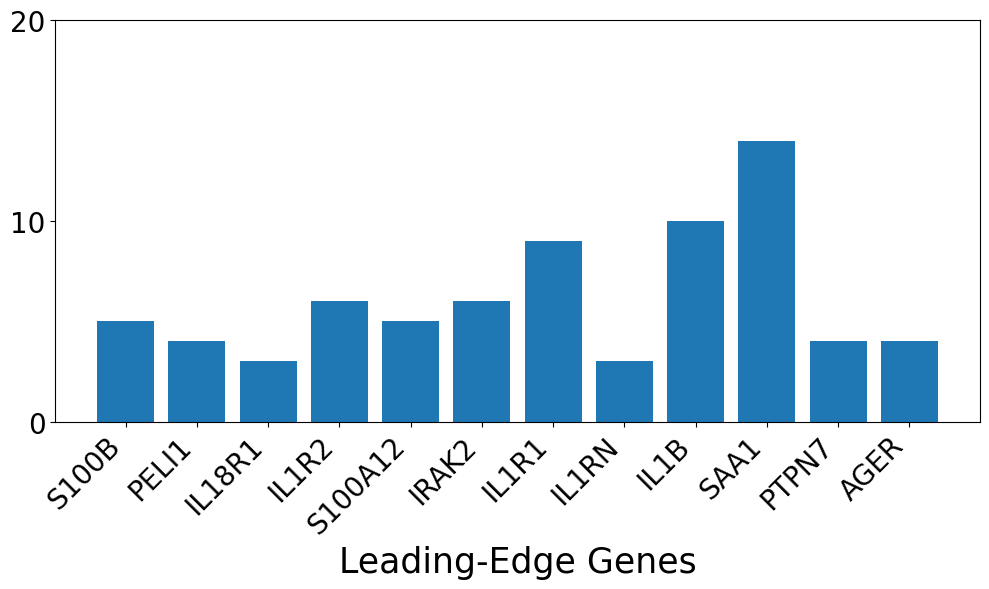

In [34]:
plot_leading_edge_genes(res, 'REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING', gene2dict)